Epoch 1/100 (SGD), Train Loss: 0.4716, Validation Loss: 0.4170
Epoch 2/100 (SGD), Train Loss: 0.2910, Validation Loss: 0.2443
Epoch 3/100 (SGD), Train Loss: 0.2282, Validation Loss: 0.1784
Epoch 4/100 (SGD), Train Loss: 0.2044, Validation Loss: 0.1576
Epoch 5/100 (SGD), Train Loss: 0.1921, Validation Loss: 0.1479
Epoch 6/100 (SGD), Train Loss: 0.1860, Validation Loss: 0.1378
Epoch 7/100 (SGD), Train Loss: 0.1803, Validation Loss: 0.1336
Epoch 8/100 (SGD), Train Loss: 0.1774, Validation Loss: 0.1286
Epoch 9/100 (SGD), Train Loss: 0.1711, Validation Loss: 0.1253
Epoch 10/100 (SGD), Train Loss: 0.1682, Validation Loss: 0.1228
Epoch 11/100 (SGD), Train Loss: 0.1641, Validation Loss: 0.1211
Epoch 12/100 (SGD), Train Loss: 0.1616, Validation Loss: 0.1182
Epoch 13/100 (SGD), Train Loss: 0.1597, Validation Loss: 0.1147
Epoch 14/100 (SGD), Train Loss: 0.1556, Validation Loss: 0.1127
Epoch 15/100 (SGD), Train Loss: 0.1535, Validation Loss: 0.1107
Epoch 16/100 (SGD), Train Loss: 0.1522, Validatio

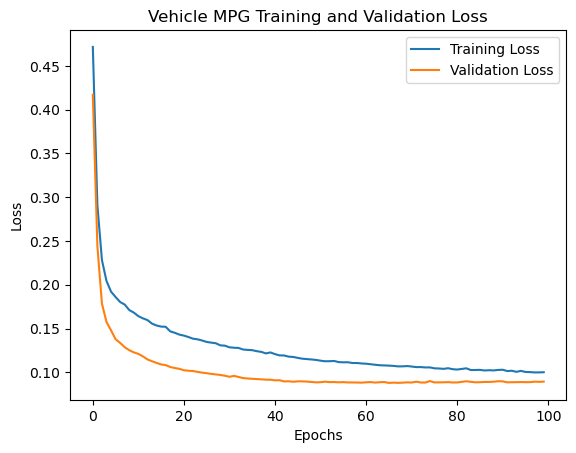

Total Testing Loss (Vehicle MPG): 0.1299
   True MPG  Predicted MPG
0      21.1      26.465823
1      36.0      37.036214
2      14.0      13.741150
3      38.0      36.362761
4      15.5      15.853136
5      13.0      14.709357
6      16.0      15.575709
7      21.0      23.686523
8      19.4      18.115633
9      29.0      31.820208


In [25]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


# 1. Download and Prepare the Vehicle MPG Dataset


# Fetch the dataset from UCI Machine Learning Repository
auto_mpg = fetch_ucirepo(id=9)

# Extract features and target
X = auto_mpg.data.features
y = auto_mpg.data.targets

# Combine features and target for easy handling
data = pd.concat([X, y], axis=1)

# Remove rows with missing target values
cleaned_data = data.dropna()
X = cleaned_data.iloc[:, :-1]
y = cleaned_data.iloc[:, -1]

# Split the data: 70% training, 15% validation, 15% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize features and target
X_mean, X_std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - X_mean) / X_std
X_val = (X_val - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

y_mean, y_std = y_train.mean(), y_train.std()
y_train = (y_train - y_mean) / y_std
y_val = (y_val - y_mean) / y_std
y_test = (y_test - y_mean) / y_std



# 2. MLP Architecture and Training


class Layer:
    def __init__(self, fan_in, fan_out, activation_function, dropout_rate=0.0):
        self.weights = np.random.uniform(-np.sqrt(6 / (fan_in + fan_out)), np.sqrt(6 / (fan_in + fan_out)), (fan_in, fan_out))
        self.bias = np.zeros((1, fan_out))
        self.activation = activation_function
        self.dropout_rate = dropout_rate
        self.dropout_mask = None
        
        # For RMSProp
        self.epsilon = 1e-7
        self.cache_weights = np.zeros_like(self.weights)
        self.cache_bias = np.zeros_like(self.bias)

    def forward(self, x, training=True):
        self.input = x
        self.z = np.dot(x, self.weights) + self.bias
        self.output = self.activation.forward(self.z)

        if training and self.dropout_rate > 0.0:
            self.dropout_mask = np.random.binomial(1, 1 - self.dropout_rate, size=self.output.shape) / (1 - self.dropout_rate)
            self.output *= self.dropout_mask

        return self.output

    def backward(self, delta, learning_rate, rmsprop=False, decay_rate=0.9):
        if self.dropout_rate > 0.0:
            delta *= self.dropout_mask

        activation_derivative = self.activation.derivative(self.z)
        delta *= activation_derivative

        grad_weights = np.dot(self.input.T, delta)
        grad_bias = np.sum(delta, axis=0, keepdims=True)

        if rmsprop:
            # RMSProp weight update
            self.cache_weights = decay_rate * self.cache_weights + (1 - decay_rate) * grad_weights**2
            self.cache_bias = decay_rate * self.cache_bias + (1 - decay_rate) * grad_bias**2

            self.weights -= (learning_rate / (np.sqrt(self.cache_weights) + self.epsilon)) * grad_weights
            self.bias -= (learning_rate / (np.sqrt(self.cache_bias) + self.epsilon)) * grad_bias
        else:
            # Vanilla SGD
            self.weights -= learning_rate * grad_weights
            self.bias -= learning_rate * grad_bias

        # Propagate delta to previous layer
        return np.dot(delta, self.weights.T)

class MultilayerPerceptron:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x, training=True):
        for layer in self.layers:
            x = layer.forward(x, training=training)
        return x

    def backward(self, loss_grad, learning_rate, rmsprop=False):
        for layer in reversed(self.layers):
            loss_grad = layer.backward(loss_grad, learning_rate, rmsprop=rmsprop)

    def train(self, X_train, y_train, X_val, y_val, loss_func, learning_rate=0.01, epochs=100, batch_size=32, rmsprop=False):
        train_losses, val_losses = [], []

        for epoch in range(epochs):
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train, y_train = X_train[indices], y_train[indices]

            for start in range(0, X_train.shape[0], batch_size):
                end = start + batch_size
                X_batch, y_batch = X_train[start:end], y_train[start:end]

                y_pred = self.forward(X_batch, training=True)
                loss_grad = loss_func.derivative(y_batch, y_pred)
                self.backward(loss_grad, learning_rate, rmsprop=rmsprop)

            train_loss = loss_func.loss(y_train, self.forward(X_train, training=False))
            val_loss = loss_func.loss(y_val, self.forward(X_val, training=False))

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            optimizer_used = "RMSProp" if rmsprop else "SGD"
            print(f"Epoch {epoch + 1}/{epochs} ({optimizer_used}), Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        return train_losses, val_losses


# 3. Define Activation and Loss Functions

class ActivationFunction:
    def forward(self, x):
        pass

    def derivative(self, x):
        pass

class Relu(ActivationFunction):
    def forward(self, x):
        return np.maximum(0, x)

    def derivative(self, x):
        return (x > 0).astype(float)

class Linear(ActivationFunction):
    def forward(self, x):
        return x

    def derivative(self, x):
        return np.ones_like(x)

class SquaredError:
    def loss(self, y_true, y_pred):
        return np.mean((y_true - y_pred)**2)

    def derivative(self, y_true, y_pred):
        return 2 * (y_pred - y_true) / y_true.size
class Softplus(ActivationFunction):
    def forward(self, x):
        return np.log(1 + np.exp(x))

    def derivative(self, x):
        return 1 / (1 + np.exp(-x))

class Mish(ActivationFunction):
    def forward(self, x):
        return x * np.tanh(np.log(1 + np.exp(x)))

    def derivative(self, x):
        sp = np.log(1 + np.exp(x))
        tanh_sp = np.tanh(sp)
        return tanh_sp + x * (1 - tanh_sp ** 2) * (1 / (1 + np.exp(-x)))



# 4. MLP Training and Evaluation

layers = [
    Layer(fan_in=X_train.shape[1], fan_out=64, activation_function=Relu(), dropout_rate=0.1),
    Layer(fan_in=64, fan_out=32, activation_function=Relu(), dropout_rate=0.1),
    Layer(fan_in=32, fan_out=1, activation_function=Linear())
]

mlp = MultilayerPerceptron(layers)
loss_func = SquaredError()


train_losses, val_losses = mlp.train(X_train.values, y_train.values.reshape(-1, 1), X_val.values, y_val.values.reshape(-1, 1), loss_func, learning_rate=0.01, epochs=100, rmsprop=False)

# Plot Training and Validation Loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Vehicle MPG Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate on Test Set
y_pred_test = mlp.forward(X_test.values)
y_pred_original = y_pred_test * y_std + y_mean
y_test_original = y_test.values
test_loss = loss_func.loss(y_test.values.reshape(-1, 1), y_pred_test)
print(f"Total Testing Loss (Vehicle MPG): {test_loss:.4f}")

# Display Predictions for 10 Random Samples
samples = np.random.choice(len(y_test), 10, replace=False)
predicted_mpg = y_pred_test[samples] * y_std + y_mean
true_mpg = y_test.values[samples] * y_std + y_mean

results = pd.DataFrame({"True MPG": true_mpg.flatten(), "Predicted MPG": predicted_mpg.flatten()})
print(results)
